In [1]:
import pickle
import numpy as np
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt
from sofia_redux.toolkit.resampling.resample import Resample
import warnings
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

standard_data_file = '/Users/dperera/test_data/fifi-ls/standard_pacman.p'
shaped_data_file = '/Users/dperera/test_data/fifi-ls/shaped_pacman.p'
standard_data = pickle.load(open(standard_data_file, "rb" ))
shaped_data = pickle.load(open(shaped_data_file, "rb"))

standard_fits_file = '/Users/dperera/test_data/fifi-ls/pacman/reduce/standard.fits'
shaped_fits_file = '/Users/dperera/test_data/fifi-ls/pacman/reduce/shaped.fits'

w_fwhm = 0.133790
xy_fwhm = 15.8
w_sigma = w_fwhm * gaussian_fwhm_to_sigma
xy_sigma = xy_fwhm * gaussian_fwhm_to_sigma
fwhms = np.array([xy_fwhm, xy_fwhm, w_fwhm])

print(standard_data['smoothing'])
print(shaped_data['smoothing'])


(15.8, 15.8, 0.033447534036345795)
(6.709642222275351, 6.709642222275351, 0.033447534036345795)


Standard Data (PACMAN = M82)

In [95]:
coordinates = standard_data['coordinates'].copy()
data = standard_data['data'].copy()
grid = standard_data['grid']
error = standard_data['error'].copy()
window = np.array(standard_data['window'])
smoothing = np.array(standard_data['smoothing'])
edge_threshold = np.array(standard_data['edge_threshold'])

mid_x = (coordinates[0].max() + coordinates[0].min()) / 2
mid_y = (coordinates[1].max() + coordinates[1].min()) / 2
mid_w = (coordinates[2].max() + coordinates[2].min()) / 2
print(mid_x, mid_y, mid_w)

center_xy = [mid_x, mid_y]
center_xy = [mid_x, 30.0]
center_xy = [grid[0][13], grid[1][36]]
center_xyw = [grid[0][13], grid[1][36], grid[2][34]]
xc, yc, wc = center_xyw

# indmax = np.nonzero(data == np.nanmax(data))[0][0]
# xc = coordinates[0, indmax]
# yc = coordinates[1, indmax] + 7.0
# wc = coordinates[2, indmax]

x, y, w = coordinates
dx = dy = xy_fwhm / 2
dw = w_fwhm / 2

sigma = np.sqrt(0.5 * smoothing)
print('N=', data.size)
print('alpha: ', smoothing)
print('sigma: ', sigma)
print('fwhm: ', xy_fwhm, w_fwhm)

print('xrange: ', x.min(), x.max())
print('yrange: ', y.min(), y.max())
print('center: ', center_xyw)
print('window:', window)
print('FWHM:', fwhms)
print('window / fwhm', window / fwhms)
print('edge_threshold', edge_threshold)
print('smoothing', smoothing)
print(smoothing / fwhms)

8.494175603124827 0.03224963102660183 157.87110786666278
N= 147200
alpha:  [15.8        15.8         0.03344753]
sigma:  [2.81069386 2.81069386 0.1293204 ]
fwhm:  15.8 0.13379
xrange:  -34.9354165200186 51.92376772626825
yrange:  -106.56829483383353 106.63279409588674
center:  [4.064583479981401, 1.4317051661664664, 157.83418115743723]
window: [47.4        47.4         0.06689507]
FWHM: [15.8     15.8      0.13379]
window / fwhm [3.         3.         0.50000051]
edge_threshold [0.7 0.7 0.5]
smoothing [15.8        15.8         0.03344753]
[1.         1.         0.25000025]


In [3]:
r2 = Resample(coordinates, data, error=error, order=2, window=window)
r3 = Resample(coordinates, data, error=error, order=[2,2,1], window=window)

Center line in $\lambda$

In [4]:
select_w = (y < (yc + dy)) & (y > (yc - dy))
select_w &= (x < (xc + dx)) & (x > (xc - dx))
w_out = np.linspace(w[select_w].min(), w[select_w].max(), 5000)

In [5]:
wfit2, werr2, wcounts, wchi2_2 = r2(xc, yc, w_out, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_counts=True, get_error=True, get_rchi2=True, jobs=-2)
print("Standard done")

wfit2_shape, werr2_shape, wchi2_2sh = r2(xc, yc, w_out, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 get_error=True, edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

wfit2_scale, werr2_scale, wchi2_2sc = r2(xc, yc, w_out, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 get_error=True, edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")

Standard done
Shaped done
Scaled done


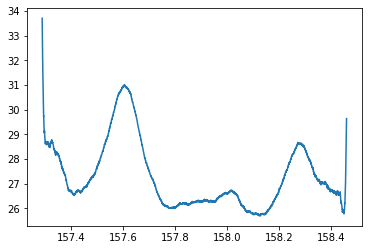

In [6]:
counts = wcounts
slice_w = w[select_w]
slice_w = np.sort(slice_w)
diff_w = np.diff(slice_w)
sampling_w = w_fwhm / diff_w[diff_w > 1e-3]
sampling_w = np.median(sampling_w)
plt.plot(w_out, werr2.ravel() * np.sqrt(wcounts.ravel()))


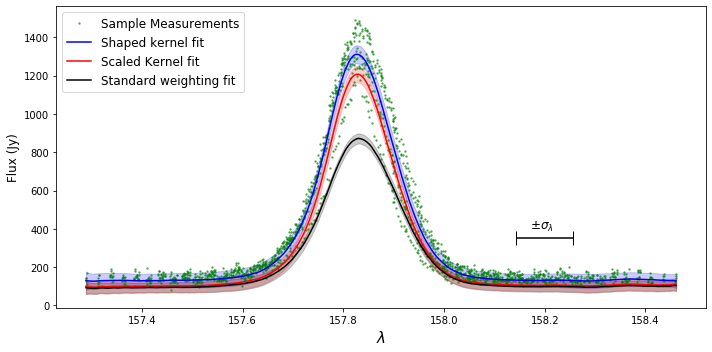

In [7]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))
ax.plot(w[select_w], data[select_w], '.', markersize=3, label='Sample Measurements', color='g', alpha=0.5)
ax.plot(w_out, wfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax.plot(w_out, wfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax.plot(w_out, wfit2.ravel(), label='Standard weighting fit', color='k')

ax.set_xlabel(r"$\lambda$", fontsize=15)
ax.set_ylabel(r"Flux (Jy)", fontsize=12)
ax.errorbar(158.2, 350, xerr=w_sigma, capsize=7, color='k')
ax.annotate(r'$\pm \sigma_{\lambda}$', [158.2, 400], xytext=[158.17, 400], fontsize=12)
# ax.annotate(r"$\Delta\lambda \approx %.2f\,/\, fwhm_{\lambda}$" % sampling_w, [157.27, 800], fontsize=12)
ax.legend(fontsize=12, loc='upper left')

ax.fill_between(w_out, wfit2_shape.ravel()+werr2_shape.ravel() * np.sqrt(counts.ravel()), wfit2_shape.ravel()-werr2_shape.ravel() * np.sqrt(counts.ravel()), alpha=.2, color='b', label=r'f(x) $\pm \sigma_{f(x)}$')
ax.fill_between(w_out, wfit2_scale.ravel()+werr2_scale.ravel() * np.sqrt(counts.ravel()), wfit2_scale.ravel()-werr2_scale.ravel() * np.sqrt(counts.ravel()), alpha=.2, color='r', label=r'f(x) $\pm \sigma_{f(x)}$')
ax.fill_between(w_out, wfit2.ravel()+werr2.ravel() * np.sqrt(counts.ravel()), wfit2.ravel()-werr2.ravel() * np.sqrt(counts.ravel()), alpha=.2, color='k', label=r'f(x) $\pm \sigma_{f(x)}$')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_lambda_M82.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()



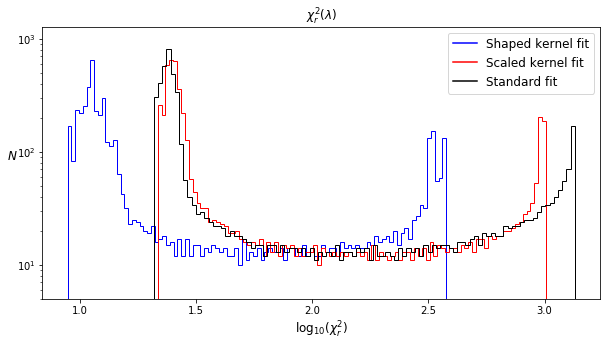

In [8]:
fig, ax = plt.subplots(1, 1, tight_layout=False, figsize=(10, 5))
weights = np.ones(w_out.size) / w_out.size
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax.hist(np.log10(wchi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b')
    ax.hist(np.log10(wchi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r')
    ax.hist(np.log10(wchi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k')
ax.set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax.set_ylabel(r"$N$", rotation=0, fontsize=12)
ax.set_title(r"$\chi_r^2(\lambda)$", fontsize=12)
ax.set_ylim(5, None)
ax.plot([], [], color='b', label='Shaped kernel fit')
ax.plot([], [], color='r', label='Scaled kernel fit')
ax.plot([], [], color='k', label='Standard fit')
ax.legend(fontsize=12, loc='upper right')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_lambda_M82_chi2.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

Line in x, contant $\lambda$ + y

In [9]:
select_x = (y < (yc + dy)) & (y > (yc - dy))
select_x &= (w < (wc + dw)) & (w > (wc - dw))
# select_x &= np.abs(x) <= 50
x_out = np.linspace(x[select_x].min(), x[select_x].max(), 5000)

In [10]:
xfit2, xchi2_2 = r2(x_out, yc, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_rchi2=True, jobs=-2)
print("Standard done")

xfit2_shape, xchi2_2sh = r2(x_out, yc, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

xfit2_scale, xchi2_2sc = r2(x_out, yc, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")

Standard done
Shaped done
Scaled done


In [11]:
aw_x = r2.fit_settings['adaptive_alpha'][:, 0, 0]
aw_x.shape
inverse_alpha_x = aw_x[:, 0]
alpha_x = 1 / inverse_alpha_x
scaled_sigma_x = ((0.5 * alpha_x * window[0]) ** 0.5)
max_sigma_x = np.nanmax(scaled_sigma_x)
min_sigma_x = np.nanmin(scaled_sigma_x)
print(min_sigma_x, max_sigma_x)

1.0307511155641012 2.3348813083430704


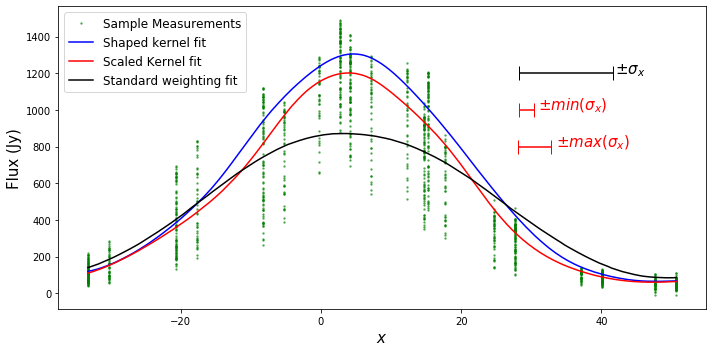

In [12]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))
ax.plot(x[select_x], data[select_x], '.', markersize=3, label='Sample Measurements', color='g', alpha=0.5)
ax.plot(x_out, xfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax.plot(x_out, xfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax.plot(x_out, xfit2.ravel(), label='Standard weighting fit', color='k')

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"Flux (Jy)", fontsize=15)

ax.errorbar(35, 1200, xerr=xy_sigma, capsize=7, color='k')
ax.annotate(r'$\pm \sigma_{x}$', [35, 1200], xytext=[42, 1200], fontsize=15)

ax.errorbar(29.3, 1000, xerr=min_sigma_x, capsize=7, color='r')
ax.annotate(r'$\pm min(\sigma_{x})$', [31, 850], xytext=[31, 1000], fontsize=15, color='r')

ax.errorbar(30.5, 800, xerr=max_sigma_x, capsize=7, color='r')
ax.annotate(r'$\pm max(\sigma_{x})$', [33.5, 1050], xytext=[33.5, 800], fontsize=15, color='r')

ax.legend(fontsize=12, loc='upper left')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_x_M82.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()


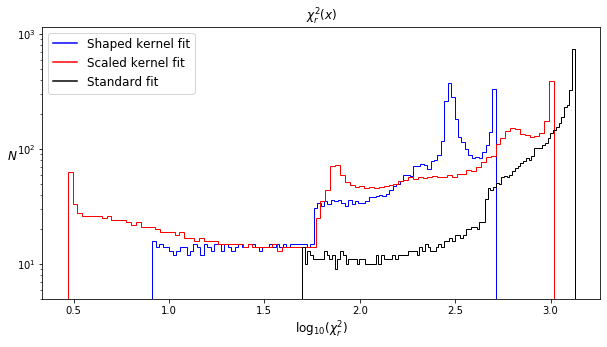

In [13]:
fig, ax = plt.subplots(1, 1, tight_layout=False, figsize=(10, 5))
weights = np.ones(x_out.size) / x_out.size
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax.hist(np.log10(xchi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b')
    ax.hist(np.log10(xchi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r')
    ax.hist(np.log10(xchi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k')
ax.set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax.set_ylabel(r"$N$", rotation=0, fontsize=12)
ax.set_title(r"$\chi_r^2(x)$", fontsize=12)
ax.set_ylim(5, None)
ax.plot([], [], color='b', label='Shaped kernel fit')
ax.plot([], [], color='r', label='Scaled kernel fit')
ax.plot([], [], color='k', label='Standard fit')
ax.legend(fontsize=12, loc='upper left')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_x_M82_chi2.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

Line in y, constant $\lambda$ + x

In [14]:
select_y = (x < (xc + dx)) & (x > (xc - dx))
select_y &= (w < (wc + dw)) & (w > (wc - dw))
select_y &= np.abs(y) <= 50
y_out = np.linspace(y[select_y].min(), y[select_y].max(), 5000)

In [15]:
yfit2, ychi2_2 = r2(xc, y_out, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_rchi2=True, jobs=-2)
print("Standard done")

yfit2_shape, ychi2_2sh = r2(xc, y_out, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

yfit2_scale, ychi2_2sc = r2(xc, y_out, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")

Standard done
Shaped done
Scaled done


In [16]:
aw_y = r2.fit_settings['adaptive_alpha'][:, 0, 0]
aw_y.shape
inverse_alpha_y = aw_y[:, 1]
alpha_y = 1 / inverse_alpha_y
scaled_sigma_y = ((0.5 * alpha_y * window[1]) ** 0.5)
max_sigma_y = np.nanmax(scaled_sigma_y)
min_sigma_y = np.nanmin(scaled_sigma_y)
print(min_sigma_y, max_sigma_y)

1.0307511155641012 2.3560138724619293


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


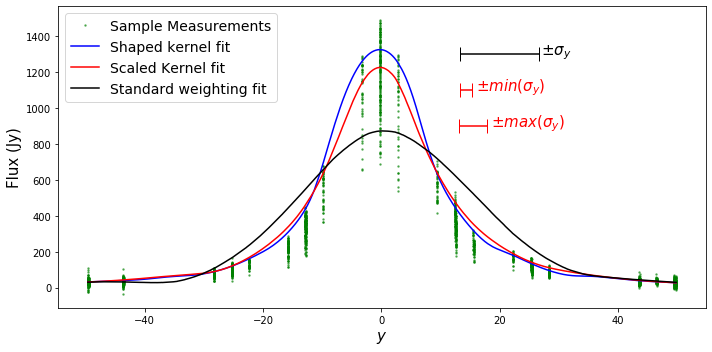

In [17]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))
ax.plot(y[select_y], data[select_y], '.', markersize=3, label='Sample Measurements', color='g', alpha=0.5)
ax.plot(y_out, yfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax.plot(y_out, yfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax.plot(y_out, yfit2.ravel(), label='Standard weighting fit', color='k')

ax.set_xlabel(r"$y$", fontsize=15)
ax.set_ylabel(r"Flux (Jy)", fontsize=15)

ax.errorbar(20, 1300, xerr=xy_sigma, capsize=7, color='k')
ax.annotate(r'$\pm \sigma_{y}$', [20, 1300], xytext=[27, 1300], fontsize=15)

ax.errorbar(14.3, 1100, xerr=min_sigma_y, capsize=7, color='r')
ax.annotate(r'$\pm min(\sigma_{y})$', [16, 950], xytext=[16, 1100], fontsize=15, color='r')

ax.errorbar(15.5, 900, xerr=max_sigma_y, capsize=7, color='r')
ax.annotate(r'$\pm max(\sigma_{y})$', [18.5, 1150], xytext=[18.5, 900], fontsize=15, color='r')

ax.legend(fontsize=14, loc='upper left')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_y_M82.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

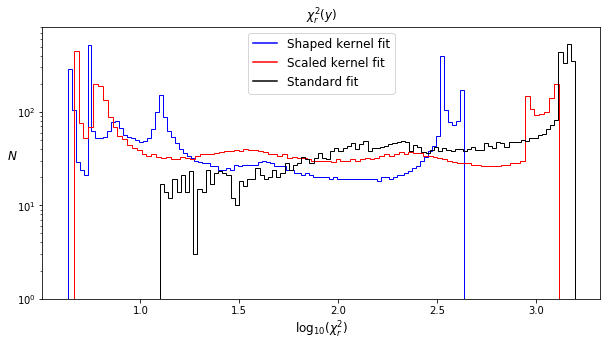

In [18]:
fig, ax = plt.subplots(1, 1, tight_layout=False, figsize=(10, 5))
weights = np.ones(y_out.size) / y_out.size
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax.hist(np.log10(ychi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b')
    ax.hist(np.log10(ychi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r')
    ax.hist(np.log10(ychi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k')
ax.set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax.set_title(r"$\chi_r^2(y)$", fontsize=12)
ax.set_ylabel(r"$N$", rotation=0, fontsize=12)
ax.set_ylim(1, None)
ax.plot([], [], color='b', label='Shaped kernel fit')
ax.plot([], [], color='r', label='Scaled kernel fit')
ax.plot([], [], color='k', label='Standard fit')
ax.legend(fontsize=12, loc='upper center')

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_y_M82_chi2.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

Full fit

In [19]:
xlim = x_out.min(), x_out.max()
ylim = y_out.min(), y_out.max()
wlim = w_out.min(), w_out.max()
gx = grid[0]
# gx = gx[(gx >= xlim[0]) & (gx <= xlim[1])]
gy = grid[1] # [20:-20]
# gy = gy[(gy >= ylim[0]) & (gy <= ylim[1])]
gw = grid[2]
# gw = gw[(gw >= wlim[0]) & (gw <= wlim[1])]

import time
t1 = time.time()
fit2, counts, chi2_2 = r2(gx, gy, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                          get_counts=True, get_rchi2=True, jobs=-2)
t2 = time.time()
print("Standard done")
print("t=", t2 - t1)

t3 = time.time()
fit2_shape, chi2_2sh = r2(gx, gy, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
aw_shaped = r2.fit_settings['adaptive_alpha'].copy()
print('Shaped done')
t4 = time.time()
print('t=', t4-t3)

t5 = time.time()
fit2_scale, chi2_2sc = r2(gx, gy, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
t6 = time.time()
print('t=', t6-t5)

aw_scaled = r2.fit_settings['adaptive_alpha'].copy()
print("Scaled done")

Standard done
t= 1.3497200012207031
Shaped done
t= 31.40386390686035
t= 24.901763200759888
Scaled done


In [20]:
image_standard = fit2[0]
image_scaled = fit2_scale[0]
image_shaped = fit2_shape[0]

Peak Fit

(72, 30)
(30,)


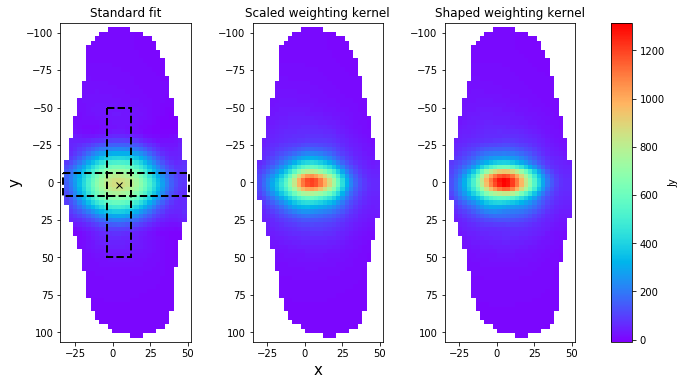

In [97]:
fig, ax = plt.subplots(1, 3, tight_layout=False, figsize=(10, 5))
fig.tight_layout(pad=1.0)

peak_standard = image_standard
peak_scaled = image_scaled
peak_shaped = image_shaped

print(peak_standard.shape)
print(gx.shape)

d = np.stack((peak_standard.ravel(), peak_scaled.ravel(), peak_shaped.ravel()))
vmin = np.nanmin(d)
vmax = np.nanmax(d)

from matplotlib.colors import LogNorm
cmap = 'hot_r'  # 'rainbow'
cmap = 'rainbow'
extent = [gx[0], gx[-1], gy[-1], gy[0]]

ax[0].imshow(peak_standard, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
ax[1].imshow(peak_scaled, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
im = ax[2].imshow(np.clip(peak_shaped, 0, None), cmap=cmap, vmin=vmin, vmax=vmax,
             extent=extent)

x_bl = xlim[0], yc - dy
x_size = xlim[1] - xlim[0], 2 * dy
x_box = patches.Rectangle((x_bl[0],x_bl[1]),x_size[0],x_size[1],linewidth=2,
                          linestyle='--',edgecolor='k',facecolor='none')

y_bl = xc - dx, ylim[0]
y_size = 2 * dx, ylim[1] - ylim[0]
y_box = patches.Rectangle((y_bl[0],y_bl[1]),y_size[0],y_size[1],linewidth=2,
                          linestyle='--',edgecolor='k',facecolor='none')

ax[0].plot(xc, yc, 'x', color='k')
ax[0].add_patch(x_box)
ax[0].add_patch(y_box)
ax[0].set_title("Standard fit", fontsize=12)
ax[1].set_title("Scaled weighting kernel", fontsize=12)
ax[2].set_title("Shaped weighting kernel", fontsize=12)

ax[1].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y', fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.075, 0.03, 0.885])
fig.colorbar(im, cax=cbar_ax, label='Jy')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_image.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

Statistics

(72, 30)
(30,)


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


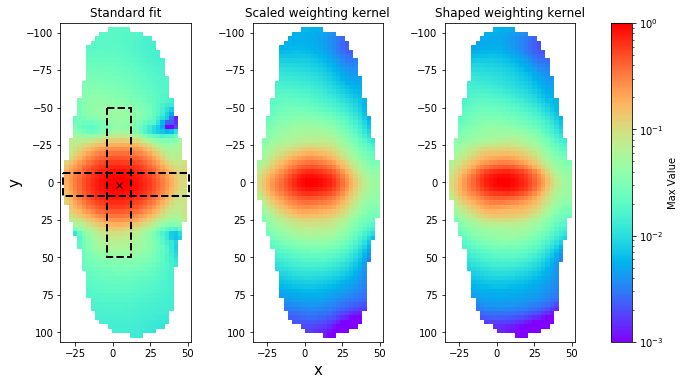

(72, 30)


In [92]:
fig, ax = plt.subplots(1, 3, tight_layout=False, figsize=(10, 5))
fig.tight_layout(pad=1.0)

peak_standard = image_standard
peak_scaled = image_scaled
peak_shaped = image_shaped

print(peak_standard.shape)
print(gx.shape)

d = np.stack((peak_standard.ravel(), peak_scaled.ravel(), peak_shaped.ravel()))
vmin = np.nanmin(d)
vmax = np.nanmax(d)

from matplotlib.colors import LogNorm
cmap = 'hot_r'  # 'rainbow'
cmap = 'rainbow'
extent = [gx[0], gx[-1], gy[-1], gy[0]]

# pcm = ax[0].pcolor(X, Y, Z,
#                    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
#                    cmap='PuBu_r')
# fig.colorbar(pcm, ax=ax[0], extend='max')

import matplotlib.colors as colors

minlog = 1e-3

log_standard = peak_standard - np.nanmin(peak_standard) + minlog
log_standard /= np.nanmax(log_standard)
ax[0].imshow(log_standard, cmap=cmap, extent=extent, vmin=minlog,
             norm=colors.LogNorm(vmin=1e-3))

log_scaled = peak_scaled - np.nanmin(peak_scaled) + minlog
log_scaled /= np.nanmax(log_scaled)
ax[1].imshow(log_scaled, cmap=cmap, extent=extent, vmin=minlog,
             norm=colors.LogNorm(vmin=minlog))

log_shaped = peak_shaped - np.nanmin(peak_shaped) + minlog
log_shaped /= np.nanmax(log_shaped)
im = ax[2].imshow(log_shaped, cmap=cmap, vmin=minlog, extent=extent,
                  norm=colors.LogNorm(vmin=minlog))

x_bl = xlim[0], yc - dy
x_size = xlim[1] - xlim[0], 2 * dy
x_box = patches.Rectangle((x_bl[0],x_bl[1]),x_size[0],x_size[1],linewidth=2,
                          linestyle='--',edgecolor='k',facecolor='none')

y_bl = xc - dx, ylim[0]
y_size = 2 * dx, ylim[1] - ylim[0]
y_box = patches.Rectangle((y_bl[0],y_bl[1]),y_size[0],y_size[1],linewidth=2,
                          linestyle='--',edgecolor='k',facecolor='none')

ax[0].plot(xc, yc, 'x', color='k')
ax[0].add_patch(x_box)
ax[0].add_patch(y_box)
ax[0].set_title("Standard fit", fontsize=12)
ax[1].set_title("Scaled weighting kernel", fontsize=12)
ax[2].set_title("Shaped weighting kernel", fontsize=12)

ax[1].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y', fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.075, 0.03, 0.885])
fig.colorbar(im, cax=cbar_ax, label='Max Value')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_log_image.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()
print(log_standard.shape)

In [86]:
print(gx.size, gy.size)
print(counts.size)
print(30 * 32)
print(np.median(counts))

30 72
2160
960
4201.0


In [30]:
# import os, glob
# from astropy.io import fits
# files = glob.glob('/Users/dperera/test_data/fifi-ls/pacman/reduce/*WSH*.fits')
# len(files)
# f = files[0]
# h = fits.getheader(f)
# data = fits.getdata(f)

In [87]:
# fields = data[0].field(0)
# from astropy import units
# print(repr(fields))
# dx = 0.00166666666666666 * units.deg
# dy = 0.00166666666666666 * units.deg
# dw = 0.02527653472239422 * units.angstrom
# print(xy_fwhm)
# print(xy_fwhm / dx.to(units.arcsec))
# print(w_fwhm / dw)

AttributeError: 'numpy.float64' object has no attribute 'field'

In [88]:
slice_x = x[select_x]
slice_x = np.sort(slice_x)
diff_x = np.diff(slice_x)
spacing_x = xy_fwhm / diff_x[diff_x > 0.1]
# plt.plot(spacing_x)
sampling_x = np.median(spacing_x)
print(sampling_x)

slice_y = y[select_y]
slice_y = np.sort(slice_y)
diff_y = np.diff(slice_y)
spacing_y = xy_fwhm / diff_y[diff_y > 0.1]
# plt.plot(spacing_y, '.')
sampling_y = np.median(spacing_y)
print(sampling_y)

slice_w = w[select_w]
slice_w = np.sort(slice_w)
diff_w = np.diff(slice_w)
# plt.plot(np.log10(diff_w), '.')
sampling_w = w_fwhm / diff_w[diff_w > 1e-3]
sampling_w = np.median(sampling_w)
print(sampling_w)


5.287162035292101
5.444581762930049
52.73233704647804


['/Users/dperera/test_data/fifi-ls/pacman/reduce/F0280_FI_IFS_7004081_RED_WXY_100471-200545.fits']
09h55m55.38s +69d40m53.4s
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   30                                                  
NAXIS2  =                   72                                                  
NAXIS3  =                   74                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DATE-OBS= '2016-02-25T09:03:57' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =               2000.0 / Coordinate equinox              

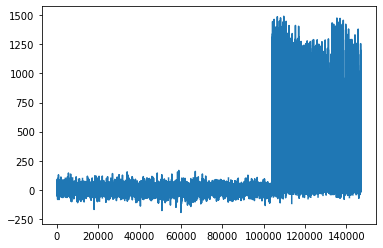

In [89]:
import os, glob
from astropy.io import fits
files = glob.glob('/Users/dperera/test_data/fifi-ls/pacman/reduce/*WXY*.fits')
print(files)
f = files[0]
hdul = fits.open(f)
# print(repr(hdul[0].header))
from astropy.coordinates import SkyCoord
from astropy import units
c = SkyCoord(ra=hdul[0].header['OBSRA'] * units.hourangle, dec=hdul[0].header['OBSDEC'] * units.degree)
print(c.to_string('hmsdms'))

# data = hdul[1].data.copy()
plt.plot(data.ravel())
print(repr(hdul[1].header))


Paper plots

/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


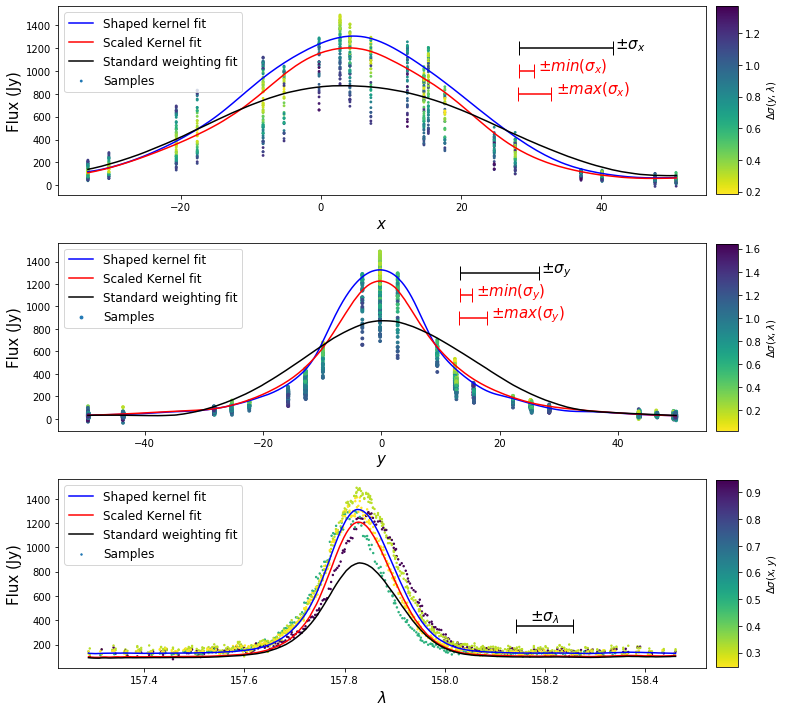

In [90]:
fig, ax = plt.subplots(3, 1, tight_layout=True, figsize=(10, 10))
from matplotlib import cm


# ax[0].plot(x[select_x], data[select_x], '.', markersize=3, label='Sample Measurements', cmap=cmap)
rx = np.hypot((y[select_x] - yc) / xy_sigma, (w[select_x] - wc) / w_sigma)

colx = ax[0].scatter(x[select_x], data[select_x], ec=None, s=8, cmap=cm.viridis_r, c=rx, label='Samples', vmax=rx.max(), vmin=rx.min())
cbar_ax = fig.add_axes([1.0, 0.725, 0.03, 0.26])
fig.colorbar(colx, cax=cbar_ax, label=r'${\Delta \sigma}(y,\lambda)$')
ax[0].plot(x_out, xfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax[0].plot(x_out, xfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax[0].plot(x_out, xfit2.ravel(), label='Standard weighting fit', color='k')

ax[0].set_xlabel(r"$x$", fontsize=15)
ax[0].set_ylabel(r"Flux (Jy)", fontsize=15)

ax[0].errorbar(35, 1200, xerr=xy_sigma, capsize=7, color='k')
ax[0].annotate(r'$\pm \sigma_{x}$', [35, 1200], xytext=[42, 1200], fontsize=15)

ax[0].errorbar(29.3, 1000, xerr=min_sigma_x, capsize=7, color='r')
ax[0].annotate(r'$\pm min(\sigma_{x})$', [31, 850], xytext=[31, 1000], fontsize=15, color='r')

ax[0].errorbar(30.5, 800, xerr=max_sigma_x, capsize=7, color='r')
ax[0].annotate(r'$\pm max(\sigma_{x})$', [33.5, 1050], xytext=[33.5, 800], fontsize=15, color='r')

ax[0].legend(fontsize=12, loc='upper left')



# Y
ry = np.hypot((x[select_y] - xc) / xy_sigma, (w[select_y] - wc) / w_sigma)
coly = ax[1].scatter(y[select_y], data[select_y], s=8, cmap=cm.viridis_r, c=ry, label='Samples', vmin=ry.min(), vmax=ry.max())
cbar_ax_y = fig.add_axes([1.0, 0.395, 0.03, 0.26])
fig.colorbar(coly, cax=cbar_ax_y, label=r'${\Delta \sigma}(x,\lambda)$')
ax[1].plot(y_out, yfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax[1].plot(y_out, yfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax[1].plot(y_out, yfit2.ravel(), label='Standard weighting fit', color='k')

ax[1].set_xlabel(r"$y$", fontsize=15)
ax[1].set_ylabel(r"Flux (Jy)", fontsize=15)

ax[1].errorbar(20, 1300, xerr=xy_sigma, capsize=7, color='k')
ax[1].annotate(r'$\pm \sigma_{y}$', [20, 1300], xytext=[27, 1300], fontsize=15)

ax[1].errorbar(14.3, 1100, xerr=min_sigma_y, capsize=7, color='r')
ax[1].annotate(r'$\pm min(\sigma_{y})$', [16, 950], xytext=[16, 1100], fontsize=15, color='r')

ax[1].errorbar(15.5, 900, xerr=max_sigma_y, capsize=7, color='r')
ax[1].annotate(r'$\pm max(\sigma_{y})$', [18.5, 1150], xytext=[18.5, 900], fontsize=15, color='r')

ax[1].legend(fontsize=12, loc='upper left')


# Lambda
rw = np.hypot((x[select_w] - xc) / xy_sigma, (y[select_w] - yc) / xy_sigma)
colw = ax[2].scatter(w[select_w], data[select_w], s=2, cmap=cm.viridis_r, c=rw, label='Samples', vmin=rw.min(), vmax=rw.max())
cbar_ax_w = fig.add_axes([1.0, 0.067, 0.03, 0.26])
fig.colorbar(colw, cax=cbar_ax_w, label=r'${\Delta \sigma}(x,y)$')

ax[2].plot(w_out, wfit2_shape.ravel(), label='Shaped kernel fit', color='b')
ax[2].plot(w_out, wfit2_scale.ravel(), label='Scaled Kernel fit', color='r')
ax[2].plot(w_out, wfit2.ravel(), label='Standard weighting fit', color='k')


ax[2].set_xlabel(r"$\lambda$", fontsize=15)
ax[2].set_ylabel(r"Flux (Jy)", fontsize=15)
ax[2].errorbar(158.2, 350, xerr=w_sigma, capsize=7, color='k')
ax[2].annotate(r'$\pm \sigma_{\lambda}$', [158.2, 400], xytext=[158.17, 400], fontsize=15)
# ax.annotate(r"$\Delta\lambda \approx %.2f\,/\, fwhm_{\lambda}$" % sampling_w, [157.27, 800], fontsize=12)
ax[2].legend(fontsize=12, loc='upper left')


plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_cross_sections.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

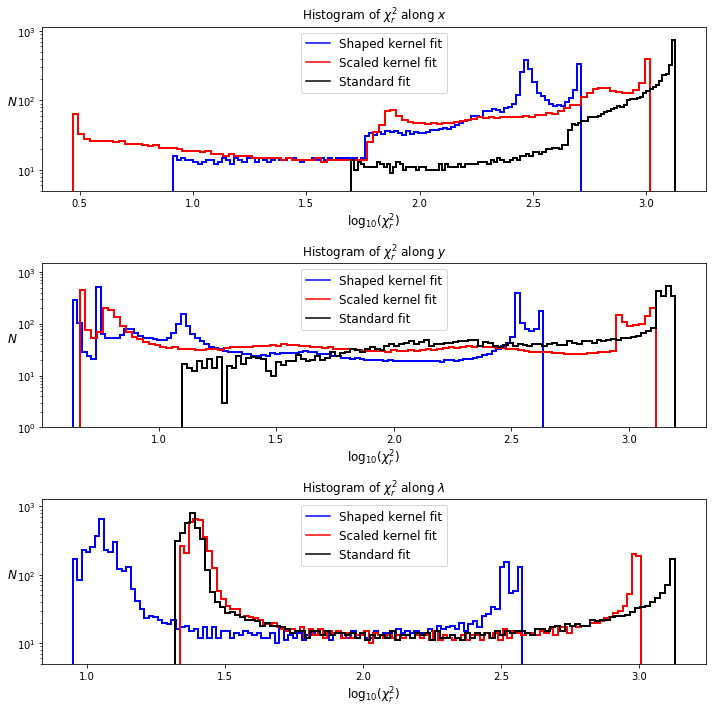

In [91]:
fig, ax = plt.subplots(3, 1, tight_layout=True, figsize=(10, 10))

weights = np.ones(w_out.size) / w_out.size
import warnings

# X
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax[0].hist(np.log10(xchi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b', lw=2)
    ax[0].hist(np.log10(xchi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r', lw=2)
    ax[0].hist(np.log10(xchi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k', lw=2)
ax[0].set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax[0].set_ylabel(r"$N$", rotation=0, fontsize=12)
ax[0].set_title(r"Histogram of $\chi_r^2$ along $x$", fontsize=12)
ax[0].set_ylim(5, None)
ax[0].plot([], [], color='b', label='Shaped kernel fit')
ax[0].plot([], [], color='r', label='Scaled kernel fit')
ax[0].plot([], [], color='k', label='Standard fit')
ax[0].legend(fontsize=12, loc='upper center')


# Y
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax[1].hist(np.log10(ychi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b', lw=2)
    ax[1].hist(np.log10(ychi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r', lw=2)
    ax[1].hist(np.log10(ychi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k', lw=2)
ax[1].set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax[1].set_title(r"Histogram of $\chi_r^2$ along $y$", fontsize=12)
ax[1].set_ylabel(r"$N$", rotation=0, fontsize=12)
ax[1].set_ylim(1, 1.5e3)
ax[1].plot([], [], color='b', label='Shaped kernel fit')
ax[1].plot([], [], color='r', label='Scaled kernel fit')
ax[1].plot([], [], color='k', label='Standard fit')
ax[1].legend(fontsize=12, loc='upper center')

# Lambda
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax[2].hist(np.log10(wchi2_2sh).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='b', lw=2)
    ax[2].hist(np.log10(wchi2_2sc).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='r', lw=2)
    ax[2].hist(np.log10(wchi2_2).ravel(), bins=100, weights=None, histtype='step',
            log=True, color='k', lw=2)
ax[2].set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax[2].set_ylabel(r"$N$", rotation=0, fontsize=12)
ax[2].set_title(r"Histogram of $\chi_r^2$ along $\lambda$", fontsize=12)
ax[2].set_ylim(5, None)
ax[2].plot([], [], color='b', label='Shaped kernel fit')
ax[2].plot([], [], color='r', label='Scaled kernel fit')
ax[2].plot([], [], color='k', label='Standard fit')
ax[2].legend(fontsize=12, loc='upper center')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_rchi2.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

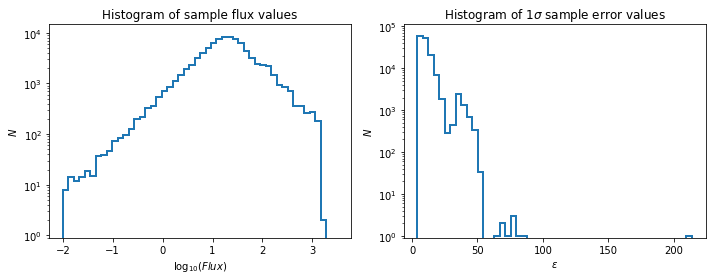

In [138]:
#plt.plot(error.ravel(), '.')
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
e = error.copy()
e = e[e > 0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax[0].hist(np.log10(data.ravel()), bins=50, histtype='step', log=True, range=[-2,3.5], lw=2)
    ax[0].set_xlabel(r"$\log_{10}(Flux)$")
    ax[0].set_ylabel(r"$N$")
    ax[0].set_ylim(0.9, None)
    ax[0].set_title(r"Histogram of sample flux values")
    ax[1].hist(10 ** np.log10(e.ravel()), bins=50, histtype='step', log=True, lw=2) # range=[0.5, 1.75]
    ax[1].set_xlabel(r"$\epsilon$")
    ax[1].set_ylabel(r"$N$")
    ax[1].set_title(r"Histogram of $1\sigma$ sample error values")
    ax[1].set_ylim(0.9, None)
    
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_sample_errors.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

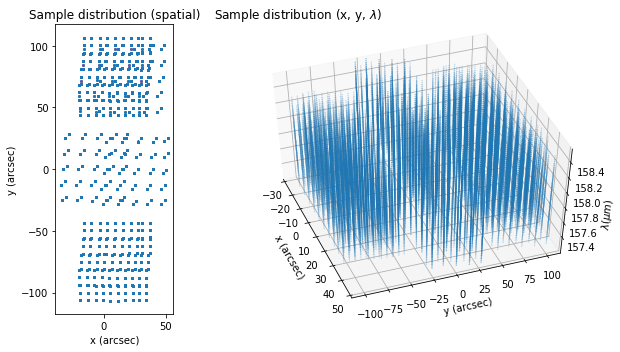

In [118]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax1.scatter(*coordinates[:2], marker='.', s=1)
ax1.set_xlabel('x (arcsec)')
ax1.set_ylabel('y (arcsec)')
ax1.set_aspect('equal')
ax1.set_title("Sample distribution (spatial)")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*coordinates, marker='.', s=0.2, alpha=0.5)
ax2.view_init(azim=340, elev=50)
ax2.set_xlim(-30, 50)
ax2.set_ylim(-110, 110)
ax2.set_xlabel('x (arcsec)')
ax2.set_ylabel('y (arcsec)')
ax2.set_zlabel(r'$\lambda (\mu m)$')
# ax2.dist = 10
ax2.set_title(r"Sample distribution (x, y, $\lambda$)", loc='left', fontsize=12)
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_sample_distribution.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

0.0034823085121331587
19.209978026622938


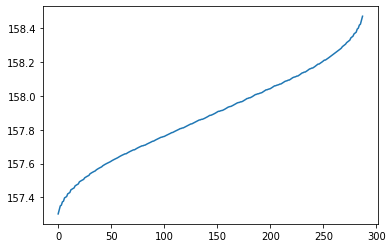

In [128]:
x, y, w = coordinates
keep = ((x > 0) & (x < 5)) & ((y > -100) & (y < -90))
#plt.plot(x[keep], y[keep], '.')
plt.plot(np.unique(w[keep]))
diffw = np.diff(np.unique(w[keep]))
print(np.median(diffw))
print(0.06689507 / np.median(diffw))

Bad fit (rchi2=1)

In [125]:
t1 = time.time()
bsmooth = smoothing.copy()
bsmooth /= 12
bfit2, bchi2 = r2(gx, gy, wc, smoothing=bsmooth, edge_threshold=edge_threshold,
                          get_counts=False, get_rchi2=True, jobs=-2)
t2 = time.time()
print("Standard done")
print("t=", t2 - t1)

Standard done
t= 1.0357029438018799


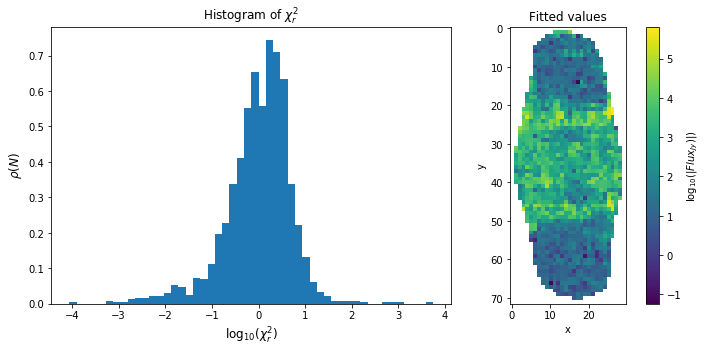

[1.31666667 1.31666667 0.00278729]


In [162]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
ax[0].hist(np.log10(bchi2.ravel()), bins=50, density=True)
ax[0].set_xlabel(r"$\log_{10}{(\chi_r^2)}$", fontsize=12)
ax[0].set_ylabel(r"$\rho(N)   $", fontsize=12)
ax[0].set_title(r"Histogram of $\chi_r^2$", fontsize=12)
im = ax[1].imshow(np.log10(abs(bfit2[0])))
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Fitted values")
fig.colorbar(im, label=r'$\log_{10}(|Flux_{Jy})|)$')
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_chi2_equal_1.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()
print(bsmooth)

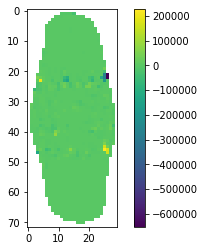

In [131]:
plt.imshow(bfit2[0])
ply